# Machine Learning in Economics - Update

**Author**

> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)  



**Prerequisites**

- [Regression](https://datascience.quantecon.org/regression.html)  


**Outcomes**

- Understand how economists use machine learning in
  academic research  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
#plt.style.use('tableau-colorblind10')
#plt.style.use('Solarize_Light2')
plt.style.use('bmh')

## Introduction

In the gender wage gap example, we had quite different results for lasso and neural networks. This is unusual and indicates some problem with one or both estimators. 

Based on the very similar neural network predicted $P(female|x)$ for actual females and males, I suspect that the problem is that the neural network is underfitting. The other notebook did not explore many network architectures largely due to computation time constraints. Here, we will use PyTorch to speed up the computation and attempt to find a better model.  

In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statsmodels as sm

def partial_linear(y, d, X, yestimator, destimator, folds=3, ymethod=None, dmethod=None):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    if ymethod == None :
        ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    if dmethod == None : 
        dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    if (len(dhat.shape)>1):
        dhat = dhat[:,1]
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

### Application: Gender Wage Gap

Remember that we were examining the gender wage gap using data from the ~~2018~~ 2020 Current Population Survey (CPS) in the US. In particular, we will use the version of the [CPS provided by the NBER](https://www.nber.org/cps/).

In [3]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
# Download CPS data
#cpsall = pd.read_stata("https://www.nber.org/morg/annual/morg20.dta")
cpsall = pd.read_stata("morg20.dta")
# take subset of data just to reduce computation time
cps = cpsall.sample(30000, replace=False, random_state=0).copy()
display(cps.head())
cps.describe()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
893,710504810164514,January,2.0,Civilian male primary individual,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0901,09012,2,2,...,720,705,0,0,0,0,0,NaN,Food preparation and serving related occupations,Food services and drinking places
122539,153311060059851,June,1.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0911,09111,1,1,...,725,710,0,1,1,1,1,14.0,Transportation and material moving occupations,Transportation and warehousing
24224,865231160805718,January,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,720,705,0,0,0,0,0,14.0,"Education, training, and library occupations",Educational services
235671,634950298881002,November,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,1201,12011,1,1,...,730,727,0,0,0,0,0,14.0,Food preparation and serving related occupations,Food services and drinking places
264248,121079060304971,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,1201,12011,1,1,...,731,728,1,0,0,0,1,NaN,Healthcare practitioner and technical occupations,8191.0


,hurespli,hhnum,cbsafips,county,centcity,smsastat,icntcity,smsa04,relref95,age,...,recnum,year,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc
count,29998.000000,30000.000000,30000.000000,30000.000000,24785.000000,29699.000000,3775.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,20929.000000
mean,1.248017,1.050267,22794.213667,25.579267,1.926811,1.186942,1.399735,3.691300,42.792200,48.781800,...,200364.281250,2020.0,725.461367,716.238567,0.053967,0.064967,0.136967,0.081267,0.099833,12.443547
std,0.617033,0.238765,16456.328404,61.435104,0.718238,0.389872,0.987978,2.592906,3.830515,18.922986,...,116372.054688,0.0,3.498569,6.903731,0.225956,0.246471,0.343818,0.273249,0.299783,2.441900
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,40.000000,16.000000,...,23.000000,2020.0,720.000000,705.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,40.000000,33.000000,...,98957.250000,2020.0,722.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,1.000000,1.000000,25540.000000,0.000000,2.000000,1.000000,1.000000,4.000000,41.000000,49.000000,...,200032.500000,2020.0,725.000000,716.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,1.000000,1.000000,37340.000000,27.000000,2.000000,1.000000,1.000000,6.000000,42.000000,64.000000,...,302111.750000,2020.0,729.000000,722.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
max,13.000000,4.000000,49740.000000,810.000000,3.000000,2.000000,7.000000,7.000000,59.000000,85.000000,...,401132.000000,2020.0,731.000000,728.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000


The variable “earnwke” records weekly earnings. Two
variables detail the hours of work. “uhours” is usual hours worked per
week, and “hourslw” is hours worked last week. We will try using each
measure of hours to construct the wage.  Let’s estimate the
unconditional gender earnings and wage gaps.

In [4]:
cps["female"] = (cps.sex==2)
cps["log_earn"] = np.log(cps.earnwke)
cps.loc[np.isinf(cps.log_earn),"log_earn"] = np.nan
cps["log_uhours"] = np.log(cps.uhourse)
cps.loc[np.isinf(cps.log_uhours), "log_uhours"] = np.nan
cps["log_hourslw"] = np.log(cps.hourslw)
cps.loc[np.isinf(cps.log_hourslw),"log_hourslw"] = np.nan
cps["log_wageu"] = cps.log_earn - cps.log_uhours
cps["log_wagelw"] = cps.log_earn - cps.log_hourslw


lm = list()
lm.append(smf.ols(formula="log_earn ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append( smf.ols(formula="log_wageu ~ female", data=cps,
                   missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_wagelw ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_earn ~ female + log_hourslw + log_uhours", data=cps,
                  missing="drop").fit(cov_type='HC0'))

/home/paul/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/paul/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
summary_col(lm, stars=True)

,log_earn I,log_wageu I,log_wagelw I,log_earn II
Intercept,6.8607***,3.2022***,3.2366***,2.0104***
,(0.0091),(0.0080),(0.0088),(0.0945)
R-squared,0.0323,0.0166,0.0136,0.3367
R-squared Adj.,0.0323,0.0165,0.0135,0.3366
female[T.True],-0.2965***,-0.1729***,-0.1746***,-0.1363***
,(0.0133),(0.0112),(0.0124),(0.0115)
log_hourslw,,,,0.0227
,,,,(0.0223)
log_uhours,,,,1.3025***
,,,,(0.0372)


The unconditional gender gap in log earnings is about -0.3. Women earn
about 30% less than men. The unconditional gender wage gap is about
18%. The last column gives the gender earnings gap conditional on
hours. This could differ from the wage gap if, for example, full time
workers are paid higher wages than part-time. Some evidence
has suggested this, and the gender earnings gap conditional on hours is about
15%.

#### Equal Pay for Equal Work?

A common slogan is equal pay for equal work. One way to interpret this
is that for employees with similar worker and job characteristics, no gender wage gap should exist.

Eliminating this wage gap across similar worker and job characteristics is one necessary
(though insufficient) condition for equality. Some of the differences (like hours in the 4th column of the above table)
might actually be a result of societal norms and/or
discrimination, so we don’t want to overgeneralize.

Nonetheless, let’s examine whether there is a gender wage gap
conditional on all worker and job characteristics. We want to ensure
that we control for those characteristics as flexibly as
possible, so we will use the partially linear model described above.

In [6]:
from patsy import dmatrices
# Prepare data
fmla  = "log_earn + female ~ log_uhours + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)"
yd, X = dmatrices(fmla,cps)
female = yd[:,1]
logearn = yd[:,2]

The choice of regularization parameter is somewhat
tricky. Cross-validation is a good way to choose the best
regularization parameter when our goal is prediction. However,
our goal here is not prediction. Instead, we want to get a well-behaved
estimate of the gender wage gap. To achieve this, we generally need a
smaller regularization parameter than what would minimize
MSE. The following code picks such a regularization parameter. Note
however, that the details of this code might not meet the technical
theoretical conditions needed for our ultimate estimate of the gender
wage gap to be consistent and asymptotically normal. The R package,
“HDM” [[mlCHS16](#id21)] , chooses the regularization parameter in way that
is known to be correct.

In [7]:
from sklearn import linear_model
# select regularization parameter
alphas = np.exp(np.linspace(-2, -12, 25))
lassoy = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,logearn)
lassod = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,female)

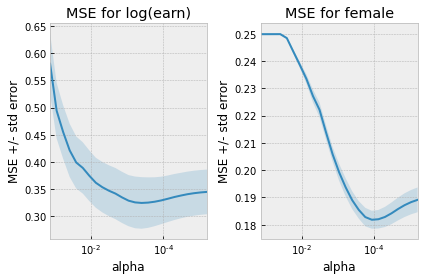

In [8]:
fig, ax = plt.subplots(1,2)

def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotlassocv(lassoy,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotlassocv(lassod,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MIGHT BE WRONG
def pickalpha(lassocv) :
    imin = np.argmin(lassocv.mse_path_.mean(axis=1))
    msemin = lassocv.mse_path_.mean(axis=1)[imin]
    se = lassocv.mse_path_.std(axis=1)[imin]
    alpha= min([alpha for (alpha, mse) in zip(lassocv.alphas_, lassocv.mse_path_.mean(axis=1)) if mse<msemin+se])
    return(alpha)

alphay = pickalpha(lassoy)
alphad = pickalpha(lassod)

In [9]:
# show results
pl_lasso = partial_linear(logearn, female, X,
                          linear_model.Lasso(alpha=lassoy.alpha_),
                          linear_model.Lasso(alpha=lassod.alpha_))
pl_lasso[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              111.0
Date:                Wed, 24 Nov 2021   Prob (F-statistic):                    7.86e-26
Time:                        11:42:06   Log-Likelihood:                         -10321.
No. Observations:               12038   AIC:                                  2.064e+04
Df Residuals:                   12037   BIC:                                  2.065e+04
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1407      0.013    -10.533      0.000      -0.167      -0.115
==============================================================================
Omnibus:                    11986.417   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2403060.344
Skew:                          -4.411   Prob(JB):                         0.00
Kurtosis:                      71.652   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


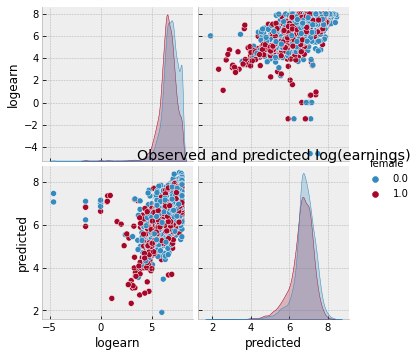

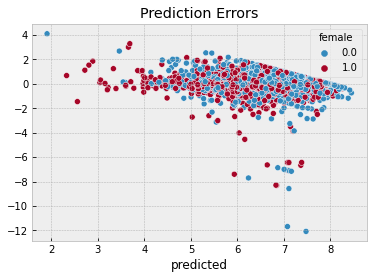

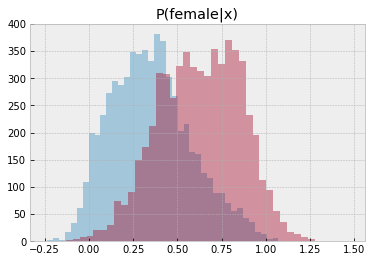

In [10]:
import seaborn as sns
# Visualize predictions
def plotpredictions(pl,logearn=logearn, female=female) :
    df = pd.DataFrame({"logearn":logearn,
                       "predicted":pl[1].flatten(),
                       "female":female,
                       "P(female|x)":pl[2].flatten()})
    sns.pairplot(df, vars=["logearn","predicted"], hue="female")
    plt.title("Observed and predicted log(earnings)")

    plt.figure()
    sns.scatterplot(df.predicted, df.logearn-df.predicted, hue=df.female)
    plt.title("Prediction Errors")

    plt.figure()
    sns.distplot(pl[2][female==0], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Male")
    sns.distplot(pl[2][female==1], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Female")
    plt.title('P(female|x)')
plotpredictions(pl_lasso)

In [11]:
pl_lasso[1].flatten()

array([5.62045083, 6.21044524, 5.43049529, ..., 7.37505721, 7.21268509,
       6.68923346])

We see that the gender earnings gap is
14%, conditional on hours, age, race, location, education,
union membership, industry, and occupation.
Compared to the gap conditional on only hours, differences in other observable characteristics in the CPS seem unable explain much, if any, of the gender earnings gap.

We can repeat the same procedure with another machine learning method in place of lasso. Let’s try it with neural networks. 

Unlike the old version of these notes, we will be careful to ensure that our neural networks are fit well. This will be easy if computation time is not too long. We will use PyTorch and a GPU to achieve this. 

We will use relatively large neural networks regularized by early stopping. Early stopping is another form of regularization. Typically we fit models by minimizing a loss function on the training data. This minimization happens iteratively through some form of gradient descent. With early stopping we stop gradient descent before reaching a minimum in the training data. Instead, we decide when to stop based on the loss function is a held out portion of the data. We stop gradient descent when the loss in this held out portion of the data stops decreasing. This is a similar idea to using cross-validation to choose the regularization parameter in lasso. 

In [90]:
from sklearn import preprocessing, pipeline
import skorch # gives compatibility between pytorch and sklearn
import torch.nn as nn
import torch
import itertools

class MLP(nn.Module):
    def __init__(self, layers, kind="regress"):
        super(MLP, self).__init__()
        self.layers=layers
        self.kind = kind
        if (kind=="regress"):
            outlayers = [nn.Linear(layers[-1],1)]
        elif (kind=="classify"):
            outlayers = [nn.Linear(layers[-1],2)]
        else:
            raise Exception(f"kind={kind} unrecognized")

        self.model=nn.Sequential(
          *itertools.chain.from_iterable(zip( (nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))),
            (nn.LeakyReLU() for i in range(1, len(layers))) )),
           *outlayers
        )
    def forward(self, X):
        return self.model(X)

epochs = 200

nny = pipeline.Pipeline(steps=[
    ("scaling", preprocessing.StandardScaler()),
    ("nn", 
      skorch.NeuralNet(
        MLP,
        module__layers = [X.shape[1],  200, 100, 50], 
        max_epochs=epochs,
        lr=0.01,
        iterator_train__shuffle=True,
        batch_size=X.shape[0]//3, 
        optimizer=torch.optim.Adam, 
        criterion=nn.MSELoss,
        callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
        device="cuda"
      )
    )]
)

X32 = np.array(X).astype(np.float32)
logearn32 = np.array(logearn).astype(np.float32).reshape((len(logearn),1))

nnd = pipeline.Pipeline(steps=[
    ("scaling", preprocessing.StandardScaler()), 
    ("nn", skorch.NeuralNet(
      MLP,
      module__kind = "classify",
      module__layers = [X.shape[1],  200, 100, 50], 
      max_epochs=epochs,
      lr=0.01,
      iterator_train__shuffle=True,
      batch_size=X.shape[0]//3, 
      optimizer=torch.optim.Adam, 
      criterion=nn.CrossEntropyLoss,
      callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
      device="cuda")) ]
)

#nnd.fit(X32, np.array(female).astype(np.int64))
#nny.fit(X32, logearn32)

In [91]:
pl_nn = partial_linear(logearn32, np.array(female).astype(np.int64), X32,
                       nny, nnd, ymethod='predict', dmethod='predict')
pl_nn[0].summary()

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       40.3752       13.2458  0.0998
      2       15.1523        3.8553  0.1028
      3        4.1429        6.2536  0.1026
      4        6.5920        5.0702  0.0992
      5        4.8459        4.2892  0.2282
      6        4.8888        3.0595  0.0829
      7        2.5963        2.3107  0.0859
      8        2.1280        2.2483  0.0872
      9        1.6434        1.3414  0.0881
     10        1.5254        1.2706  0.0873
     11        1.2037        1.3515  0.0866
     12        0.9039        1.6323  0.1988
     13        0.8108        0.9705  0.0795
     14        0.6466        0.9912  0.0860
     15        0.6091        1.1094  0.0794
     16        0.4769        1.2404  0.0877
     17        0.4284        0.8530  0.0834
     18        0.3645        0.8280  0.0797
     19        0.3057        0.9669  0.0804
     20        0.2874        0.9360  0.2333
     21        0.2242        0.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              65.48
Date:                Wed, 24 Nov 2021   Prob (F-statistic):                    6.44e-16
Time:                        12:50:57   Log-Likelihood:                         -14300.
No. Observations:               12038   AIC:                                  2.860e+04
Df Residuals:                   12037   BIC:                                  2.861e+04
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1247      0.015     -8.092      0.000      -0.155      -0.094
==============================================================================
Omnibus:                     4851.640   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           238440.994
Skew:                          -1.181   Prob(JB):                         0.00
Kurtosis:                      24.675   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


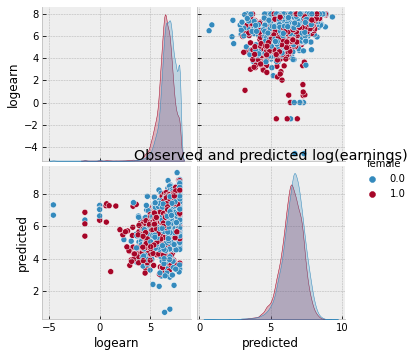

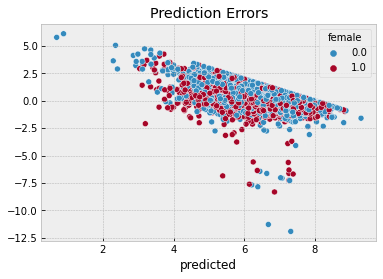

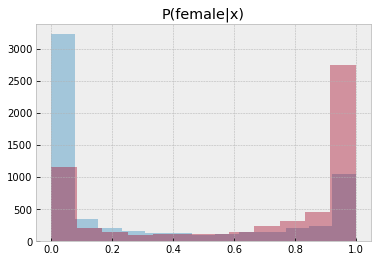

In [92]:
plotpredictions(pl_nn)

In [89]:
summary_col([pl_lasso[0], pl_nn[0]], model_names=["Lasso", "Neural Network"] ,stars=False)

,Lasso,Neural Network
x1,-0.1407,-0.0831
,(0.0134),(0.0159)
R-squared,0.0110,0.0027
R-squared Adj.,0.0109,0.0026


### Other Applications

Machine learning can be used to
estimate nuisance functions in many other situations. The partially linear model can easily be
extended to situations where the regressor of interest, $ d $ , is
endogenous and instruments are available. See [[mlCCD+18](#id14)]
for details and additional examples.

## Heterogeneous Effects

A third area where economists are using machine learning is to
estimate heterogeneous effects.

Some important papers in this area are [[mlAI16](#id18)] ,
[[mlWA18](#id17)] , and [[mlCDDFV18](#id16)] .

We will explore this is more depth in [heterogeneity](https://datascience.quantecon.org/heterogeneity.html).

## References

<a id='id18'></a>
\[mlAI16\] Susan Athey and Guido Imbens. Recursive partitioning for heterogeneous causal effects. *Proceedings of the National Academy of Sciences*, 113(27):7353–7360, 2016. URL: [http://www.pnas.org/content/113/27/7353](http://www.pnas.org/content/113/27/7353), [arXiv:http://www.pnas.org/content/113/27/7353.full.pdf](https://arxiv.org/abs/http://www.pnas.org/content/113/27/7353.full.pdf), [doi:10.1073/pnas.1510489113](https://doi.org/10.1073/pnas.1510489113).

<a id='id14'></a>
\[mlCCD+18\] Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo, Christian Hansen, Whitney Newey, and James Robins. Double/debiased machine learning for treatment and structural parameters. *The Econometrics Journal*, 21(1):C1–C68, 2018. URL: [https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097), [arXiv:https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097](https://arxiv.org/abs/https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097), [doi:10.1111/ectj.12097](https://doi.org/10.1111/ectj.12097).

<a id='id16'></a>
\[mlCDDFV18\] Victor Chernozhukov, Mert Demirer, Esther Duflo, and Iván Fernández-Val. Generic machine learning inference on heterogenous treatment effects in randomized experimentsxo. Working Paper 24678, National Bureau of Economic Research, June 2018. URL: [http://www.nber.org/papers/w24678](http://www.nber.org/papers/w24678), [doi:10.3386/w24678](https://doi.org/10.3386/w24678).

<a id='id21'></a>
\[mlCHS16\] Victor Chernozhukov, Chris Hansen, and Martin Spindler. hdm: high-dimensional metrics. *R Journal*, 8(2):185–199, 2016. URL: [https://journal.r-project.org/archive/2016/RJ-2016-040/index.html](https://journal.r-project.org/archive/2016/RJ-2016-040/index.html).

<a id='id12'></a>
\[mlKLL+17\] Jon Kleinberg, Himabindu Lakkaraju, Jure Leskovec, Jens Ludwig, and Sendhil Mullainathan. Human Decisions and Machine Predictions*. *The Quarterly Journal of Economics*, 133(1):237–293, 08 2017. URL: [https://dx.doi.org/10.1093/qje/qjx032](https://dx.doi.org/10.1093/qje/qjx032), [arXiv:http://oup.prod.sis.lan/qje/article-pdf/133/1/237/24246094/qjx032.pdf](https://arxiv.org/abs/http://oup.prod.sis.lan/qje/article-pdf/133/1/237/24246094/qjx032.pdf), [doi:10.1093/qje/qjx032](https://doi.org/10.1093/qje/qjx032).

<a id='id13'></a>
\[mlKLMO15\] Jon Kleinberg, Jens Ludwig, Sendhil Mullainathan, and Ziad Obermeyer. Prediction policy problems. *American Economic Review*, 105(5):491–95, May 2015. URL: [http://www.aeaweb.org/articles?id=10.1257/aer.p20151023](http://www.aeaweb.org/articles?id=10.1257/aer.p20151023), [doi:10.1257/aer.p20151023](https://doi.org/10.1257/aer.p20151023).

<a id='id17'></a>
\[mlWA18\] Stefan Wager and Susan Athey. Estimation and inference of heterogeneous treatment effects using random forests. *Journal of the American Statistical Association*, 0(0):1–15, 2018. URL: [https://doi.org/10.1080/01621459.2017.1319839](https://doi.org/10.1080/01621459.2017.1319839), [arXiv:https://doi.org/10.1080/01621459.2017.1319839](https://arxiv.org/abs/https://doi.org/10.1080/01621459.2017.1319839), [doi:10.1080/01621459.2017.1319839](https://doi.org/10.1080/01621459.2017.1319839).